**task: order and sort mp3s**  

criteria:  
<font color="green"></font>
a) first/last song the best from list (use model cat1)  
b) durations should fit  
c) song selection: artists evenly distributed (TODO)

In [ ]:
# user parameters
path_str = "test_songs/M"         # path where the MP3 files to be selected/ordered are located
best_first = ""                   # insert song name (without .mp3) if specific first song is desired (else leave EMPTY!!)
best_last = ""                    # insert song name (without .mp3) if specific last song is desired (else leave EMPTY!!)
keeps = []                        # let user decide if a selection of songs HAS TO be included
rm_songs = []                     # let user decide if a selection of songs HAS TO be excluded
space_total = (80*60-1)           # space in seconds

In [17]:
%matplotlib notebook

#imports
from pathlib import Path
import os
import eyed3
import eyed3.id3
from tqdm import tqdm
import math
import pywt
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import librosa                   # load in mp3 data
import pydub                     # to get waveform
import PIL
from PIL import Image, ImageDraw # for drawing song duration bar
import io                        # to get from plt output to im
from librosa.core.audio import __audioread_load
                                 # use more basic function, quicker loading time
import pickle
import random                    # test the likelihood of correct categorization
from fastai.vision.all import *
                                 # following lines: omits error for loading trained models on windows
import pathlib
temp = pathlib.PosixPath
pathlib.PosixPath = pathlib.WindowsPath

import pandas as pd
from mutagen.mp3 import MP3      # to get the duration of MP3s
                                 # to describe song fitness distribution as sigmoid
from scipy.optimize import curve_fit
                                 # to quickly find the fuzzy str matches
from difflib import SequenceMatcher
import datetime

In [2]:
# path to MP3 folder
mp3_path = Path(r""+path_str)
mp3s = [f for f in os.listdir(mp3_path) if f.endswith(".mp3")]
mp3s

['03 - Valentine.mp3',
 '04 - Still.mp3',
 '05 - Wait For You.mp3',
 '08 - Through Glass.mp3',
 '09 - Morei Sky.mp3',
 '16 - Off We Go.mp3',
 'Craig Irving - 01. Let Go.mp3',
 'Daniel Powter - Do You Wanna Get Lucky (Official Video).mp3',
 'Daniel Powter – Perfect For Me (Official Lyrics Video).mp3',
 "FINNEAS - 01. Can't Wait To Be Dead (Explicit).mp3",
 "FINNEAS - 01. What They'll Say About Us.mp3",
 'I Sat By The Ocean - Queens Of The Stone Age.mp3',
 'Instant History - Biffy Clyro.mp3',
 'Knights Of Cydonia - Muse.mp3',
 'Last Day Under the Sun - Volbeat.mp3',
 'Let It Burn - Volbeat.mp3',
 'New Born - Muse.mp3',
 'Resistance - Muse.mp3',
 'Space - Biffy Clyro.mp3',
 'Tell Them Who You Are.mp3',
 'theyouth.mp3',
 'Tiny Indoor Fireworks - Biffy Clyro.mp3']

In [3]:
def scale_1d_data(data, *args):
    # decimate data to not lose contrast
    # fixed len, e.g. 1000 --> 78000/x = 1000
    data = data[::max(1, int(len(data)/500))]
    data = np.array(data)
    if len(args) == 0:
        minmax_goal = [0, 255]
        minmax = [min(data), max(data)]
    elif len(args) == 1:
        minmax_goal = [0, 255]
        minmax = args[0]
    else:
        minmax_goal = args[1]
        minmax = args[0]
    # scale values
    data = data - minmax[0] # all positive values
    data = data/(minmax[1] - minmax[0]) # standardized to 1
    return minmax_goal[0] + data*(minmax_goal[1] - minmax_goal[0])

def get_im_from_1d_data(data, *args):
    if len(args) > 1:
        data_scaled = scale_1d_data(data, args[0], args[1])
    elif len(args) > 0:
        data_scaled = scale_1d_data(data, args[0])
    else:
        data_scaled = scale_1d_data(data)
    # add artifical y dimension (same values) to get data in form of 2d image
    # don't add to much y values, otherwise it will take too long
    added_arti_y_data = [list(data_scaled) for i in range( max(10, int(len(data)/500)) )]
    return Image.fromarray(np.array(added_arti_y_data).astype(np.uint8))

def get_im_from_plt(fig):
    # from https://web-backend.icare.univ-lille.fr/tutorials/convert_a_matplotlib_figure
    # draw the renderer
    fig.canvas.draw()
    # Get the RGBA buffer from the figure
    w, h = fig.canvas.get_width_height()
    buf = np.fromstring(fig.canvas.tostring_argb(), dtype=np.uint8)
    buf.shape = (w, h, 4)
    # canvas.tostring_argb give pixmap in ARGB mode. Roll the ALPHA channel to have it in RGBA mode
    buf = np.roll(buf, 3, axis = 2)
    return Image.frombytes("RGBA", (w, h), buf.tostring())

def get_im_from_data(y, data_2d=False):
    f = plt.figure(figsize = (7,5))
    plt.xticks([])
    plt.yticks([])
    # TODO find way to suppress visual output
    if data_2d:
        _ = plt.imshow(y, aspect="auto")
    else:
        _ = plt.plot(y)
    f.canvas.draw()
    im = PIL.Image.frombytes('RGB', f.canvas.get_width_height(), f.canvas.tostring_rgb())
    #im = get_im_from_plt(f)
    w, h = im.size
    return im.crop((90, 60, w-70, h-55))

def get_wavelet(sos, y, padding_len=500):
    filtered = signal.sosfilt(sos, y)
    # save data: decimate list
    filtered_reduced = filtered[::1000]
    # add padding to remove cone of influence in wavelets
    padding = [0 for i in range(padding_len)]
    # plot wavelet low pass
    ctw_data = ctw_out(padding + list(filtered_reduced) + padding)
    # remove padding in wavelet
    return ctw_data[:,len(padding):-len(padding)]

def get_lo_cwt_data(y):
    # reduce amount of data --> low pass filter
    sos = signal.butter(5, 0.1, 'lp', fs=sr, output='sos')
    return get_wavelet(sos, y)

def get_lo_hi_im(y, type_="lo"):
    if type_ == "lo":
        cwt_data = get_lo_cwt_data(y)
    else:
        cwt_data = get_hi_cwt_data(y)
    vmax=abs(cwt_data).max()
    cwt_data = cwt_data+vmax # all positive values
    cwt_data = cwt_data/(2*vmax) # standardized to 1
    cwt_data = cwt_data*255 # set max to 255
    return Image.fromarray(cwt_data)

def get_hi_data(y, sr):
    # reduce amount of data --> high pass filter
    sos = signal.butter(10, 11024, 'hp', fs=sr, output='sos')
    filtered = signal.sosfilt(sos, y)
    # save data: decimate list
    return filtered[::1000]

def get_lo_data(y, sr):
    # reduce amount of data --> high pass filter
    sos = signal.butter(5, 0.1, 'lp', fs=sr, output='sos')
    filtered = signal.sosfilt(sos, y)
    # save data: decimate list
    return filtered[::1000]

def get_hi_cwt_data(y):
    # reduce amount of data --> high pass filter
    sos = signal.butter(10, 11024, 'hp', fs=sr, output='sos')
    return get_wavelet(sos, y)

def get_vol_data(y):
    # volume information
    return librosa.feature.rms(y, center=True)[0]

def get_dur_im(y, sr, max_dur=20):
    perc_of_total = ((len(y)/sr)/60)/max_dur
    part_dur = PIL.Image.new(mode = "RGB", size = (500, 50))
    draw = ImageDraw.Draw(part_dur)
    draw.rectangle([0, 0, part_dur.width*perc_of_total, part_dur.height], fill=(255,255,255), outline=None, width=1)
    return part_dur

def get_all_info_im(y, sr):
    all_parts = PIL.Image.new(mode = "RGB", size = (500, 500))
    part_dur = get_dur_im(y, sr)
    part_vol = get_im_from_1d_data(get_vol_data(y), [0, 0.5], [0, 255]).resize((500,150))
    part_hi = get_im_from_1d_data(get_hi_data(y, sr)).resize((500,150))
    part_lo = get_im_from_1d_data(get_lo_data(y, sr)).resize((500,150))#get_lo_hi_im(y).resize((500,150))
    all_parts.paste(part_dur, (0, 0))
    all_parts.paste(part_vol, (0, 50))
    all_parts.paste(part_hi, (0, 200))
    all_parts.paste(part_lo, (0, 350))
    return all_parts.resize((200,200))

def store_song_info_im(mp3):
    #y, sr = librosa.load(os.path.join(mp3_path, mp3)) # TODO takes too long, alternative see below
    y, sr = __audioread_load(os.path.join(mp3_path, mp3), 0, None, "float16") #, offset, duration, dtype
    im = get_all_info_im(y[0], sr)
    im.save(mp3_path/((str(Path(mp3).stem)+".png")))

In [4]:
for mp3 in tqdm(mp3s):
    store_song_info_im(mp3)

100%|██████████| 22/22 [00:31<00:00,  1.44s/it]


In [5]:
def get_cat():
    pass

learn_c1 = load_learner(Path("export_cat1.pkl"))

In [6]:
# read tags from mp3 files and predict the class (apply model)

pics = [Path(mp3_path)/f for f in os.listdir(mp3_path) if f.endswith(".png")]
pic_stems = []
cats = [[] for i in range(3)]
artists = []
durs = []

for pic in pics:
    # identifier (file name)
    pic_stems.append(pic.stem)
    # tag infos
    tag = eyed3.id3.tag.Tag()
    tag.parse(os.path.join(mp3_path, pic.stem+".mp3"))
    artists.append(tag.artist)
    # song duration
    audio = MP3(os.path.join(mp3_path, pic.stem+".mp3"))
    durs.append(audio.info.length)
    # prediction
    pred = learn_c1.predict(pic)[-1]
    for i in range(3):
        cats[i].append(float(pred[i]))

Frame 'SYLT' is not yet supported, using raw Frame to parse


Frame 'SYLT' is not yet supported, using raw Frame to parse


Frame 'SYLT' is not yet supported, using raw Frame to parse


Frame 'SYLT' is not yet supported, using raw Frame to parse


In [7]:
df_1 = pd.DataFrame(np.transpose([pic_stems, *cats, artists, durs]))

In [9]:
if len(best_first) == 0
    best_first = df_1.sort_values(1, ascending=False)[0].tolist()[0]
best_first

'theyouth'

In [13]:
# TODO add criteria in form of user parameters
#best_last = df_1[df_1[4] != "Muse"].sort_values(3, ascending=False)[0].tolist()[0]
if len(best_last) == 0:
    best_last = df_1.sort_values(3, ascending=False)[0].tolist()[0]
best_last

'Tell Them Who You Are'

In [15]:
# convert to numeric (for some reason not done automatically)
for c in df_1.columns:
    try:
        df_1[c] = pd.to_numeric(df_1[c])
    except ValueError:
        pass

In [16]:
# how much space is already used up by necessary songs

to_include = sum(df_1[df_1[0].isin(keeps + [best_first, best_last])][5].tolist())
space_left = space_total - to_include
space_left

4327.001247165533

In [19]:
# load model that was trained with song transitions
learn_c2 = load_learner(Path("export_cat2.pkl"))

In [20]:
# generate input (images) type for learn_c2 (pair of 2 songs)

conts_count = 0
for s1 in pic_stems:
    for s2 in pic_stems:
        if s1 == s2:
            conts_count += 1
            continue
        s1_im = Image.open(mp3_path/str(s1+".png")).resize((200,100))
        s2_im = Image.open(mp3_path/str(s2+".png")).resize((200,100))
        all_parts = PIL.Image.new(mode = "RGB", size = (200, 200))
        all_parts.paste(s1_im, (0, 0))
        all_parts.paste(s2_im, (0, 100))
        all_parts.save(mp3_path/"pairs"/str(s1 + "_NICOASPLITTER_" + s2 + ".png"))
conts_count

22

In [21]:
# get model predictions for all possible song transitions

cats = [[] for i in range(4)]
s1s = []
s2s = []
for pic in os.listdir(mp3_path/"pairs"):
    # identifier (file name)
    pic_stem = pic.split(".png")[0]
    s1s.append(pic_stem.split("_NICOASPLITTER_")[0])
    s2s.append(pic_stem.split("_NICOASPLITTER_")[1])
    # prediction
    pred = learn_c2.predict(mp3_path/"pairs"/pic)
    #preds.append(pred[0])
    #full_preds.append(pred)
    for i in range(4):
        cats[i].append(float(pred[-1][i]))

In [29]:
df_2 = pd.DataFrame(np.transpose([s1s, s2s, *cats]))

# convert to numeric (for some reason not done automatically)
for c in df_2.columns:
    try:
        df_2[c] = pd.to_numeric(df_2[c])
    except ValueError:
        pass

In [30]:
# get the five best start and end songs

In [32]:
def get_dur(songs):
    return sum(df_1[df_1[0].isin(songs)][5].tolist())

In [63]:
# test ordered song selection for criteria
def test_random_it(shuffled, detailed=False):
    crits = []
    crits.append(float(df_1[df_1[0] == shuffled[-1]][3]) < 0.75)
    # missing keeps
    crits.append(len([k for k in keeps if k not in shuffled]) > 0)
    # distance measures (artists should not follow directly or semi-directly)
    shuffled_artists = [df_1[df_1[0] == s][4].tolist()[0] for s in shuffled]
    for d in [1,2,3]:
        crits.append(any([shuffled_artists[i]==shuffled_artists[i+d] for i in range(len(shuffled_artists) - d)]))
    # NEW CRITERION
    #crits.append(min(get_fit(shuffled, False)) < 0.0001)
    if detailed:
        return crits
    return any(crits)

# take an ordered list of songs and get transition fit
def get_fit(shuffled, get_sum=True):
    #shuffled = ["theyouth"] + shuffled # add the fixed first song
    likelihoods_adj = [float(df_2[(df_2[0] == shuffled[i]) & (df_2[1] == shuffled[i+1])][4]) for i in range(len(shuffled) - 1)]
    if not get_sum:
        return likelihoods_adj
    return sum(likelihoods_adj)

In [70]:
# fix the first and last three songs optimally, randomize the rest
# problem: only local optimization
# --> v2 includes the mean options afterwards as well
def best_start_v2(start_song, n, opts, winner_ind=0):
    # opts: options to draw from
    # winner_ind: 0 = choose song with best fit, 1: choose song with second best fit, ...
    out = [start_song]
    current_song = start_song
    for i in range(n-1):
        df_2_subset = df_2[(df_2[0] == current_song) & (df_2[1].isin(opts))]
        # get the mean fit from all next songs
        df_2_subset2 = df_2[df_2[0].isin(opts)]
        mean_next = []
        # do not just optimize locally, otherwise global low values likely
        for i in range(len(df_2_subset)):
            further_opts = df_2_subset2[df_2_subset2[0] == df_2_subset[1].iloc[i]][4].tolist()
            mean_next.append( np.mean(further_opts) )
        df_2_subset["mean_next"] = mean_next
        df_2_subset["composite"] = df_2_subset["mean_next"]*df_2_subset[4]
        df_2_subset.sort_values("composite", ascending=False, inplace=True)
        next_best_song = df_2_subset[1].iloc[winner_ind]
        out.append(next_best_song)
        opts = [o for o in opts if not o == next_best_song] # remove from options
        current_song = next_best_song
    return [out, opts] # opts: remaining songs

In [71]:
# fix the first and last three songs optimally, randomize the rest
def best_end_v2(end_song, n, opts, winner_ind=0):
    # opts: options to draw from
    # winner_ind: 0 = choose song with best fit, 1: choose song with second best fit, ...
    out = [end_song]
    current_song = end_song
    for i in range(n-1):
        df_2_subset = df_2[(df_2[1] == current_song) & (df_2[0].isin(opts))]
        # get the mean fit from all previous songs
        df_2_subset2 = df_2[df_2[1].isin(opts)]
        mean_prev = []
        # do not just optimize locally, otherwise global low values likely
        for i in range(len(df_2_subset)):v
            further_opts = df_2_subset2[df_2_subset2[1] == df_2_subset[0].iloc[i]][4].tolist()
            mean_prev.append( np.mean(further_opts) )
        df_2_subset["mean_prev"] = mean_prev
        df_2_subset["composite"] = df_2_subset["mean_prev"]*df_2_subset[4]
        
        df_2_subset.sort_values("composite", ascending=False, inplace=True)
        next_best_song = df_2_subset[0].iloc[winner_ind]
        out = [next_best_song] + out #.append(next_best_song)
        opts = [o for o in opts if not o == next_best_song] # remove from options
        current_song = next_best_song
    return [out, opts] # opts: remaining songs

In [79]:
#begin/end chunk algorithm
opts = [i for i in df_1[0].tolist() if i not in [best_first, best_last]+rm_songs]

current_set = [best_first] + opts + [best_last]

current_first = best_first
current_last = best_last
n_start = 5
n_end = 5

# alternate chaining from start and end
songs = [] # final list of songs
all_start_songs = [best_first]
all_end_songs = [best_last]
# iterate as long as space is not optimally filled
while get_dur(songs) < space_total and len(opts) > 0:
    start_ind = 0
    end_ind = 0
    next_start_songs, opts = best_start_v2(current_first, 2, opts, start_ind)
    all_start_songs.append(next_start_songs[1])
    next_end_songs, opts = best_end_v2(current_last, 2, opts, end_ind)
    all_end_songs = [next_end_songs[0]] + all_end_songs
    current_first = next_start_songs[1]
    current_last = next_end_songs[0]
    songs = all_start_songs + all_end_songs

C:\Users\a\miniconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
C:\Users\a\miniconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
C:\Users\a\miniconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/p

<IPython.core.display.Javascript object>


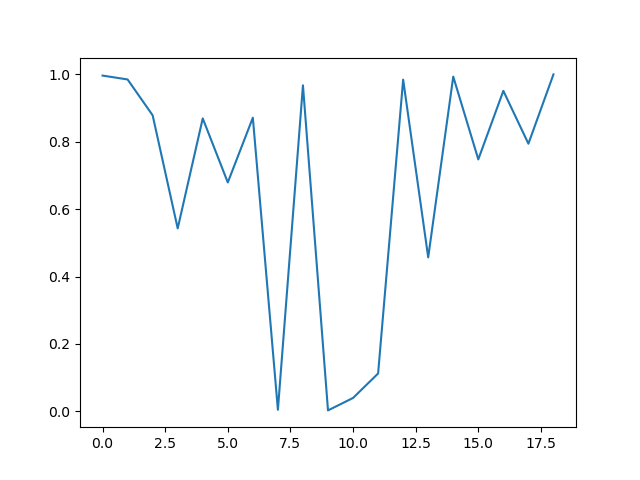

In [80]:
plt.figure()
plt.plot(get_fit(songs, False))

In [81]:
# looks good --> are all necessary tracks included?
missings = [k for k in keeps if k not in songs]
missings

[]

In [82]:
# are the artists distant enough? --> looks good :)
test_random_it(songs, True) # all should be false

[False, False, True, False, False]

In [83]:
# if space exceeded, remove songs with worst transitions

# remove the worst transition(s) first
# from min_ind to min_ind+1

songs_red = songs

while space_total < get_dur(songs_red + missings):
    trans = get_fit(songs_red, False)
    df_tmp = pd.DataFrame(np.transpose([list(range(len(trans))), trans]))
    df_tmp.sort_values(1, inplace=True)
    kick = []
    for i in range(len(df_tmp)):
        min_ind = int(df_tmp[0][i])
        if min_ind <= 3 or min_ind > len(trans) - 2:
            continue
        #min_ind = [i for i, v in enumerate(trans) if v == min(trans)][0]
        kick = [songs_red[min_ind+i] for i in range(2) if songs_red[min_ind+i] not in keeps]
        if len(kick) > 0:
            break
    if space_total < get_dur(songs_red + missings) - get_dur(kick):
        songs_red = [s for s in songs_red if s not in kick]
    elif len(kick) == 1:
        songs_red = [s for s in songs_red if s not in kick]
    elif all([space_total > get_dur([k]) for k in kick]):
        # only remove the shorter song
        rm = df_1[df_1[0].isin(kick)].sort_values(5).iloc[0][0]
        songs_red = [s for s in songs_red if s != rm]
    else:
        # only remove the longer song
        rm = df_1[df_1[0].isin(kick)].sort_values(5, ascending=False).iloc[0][0]
        songs_red = [s for s in songs_red if s != rm]

In [84]:
space_total, get_dur(songs_red + missings)

(4799, 4528.237129535148)

<IPython.core.display.Javascript object>


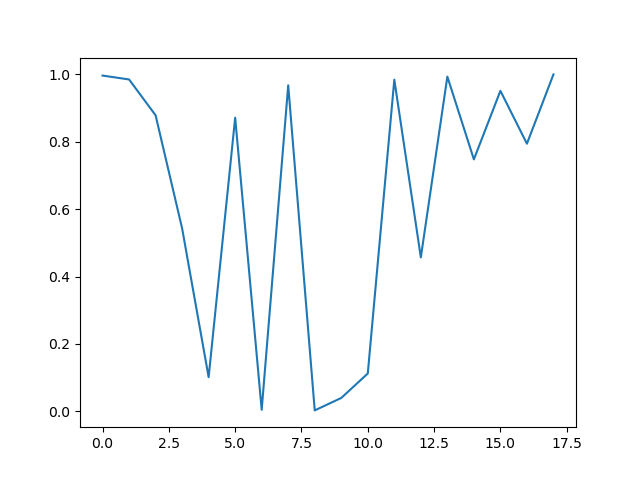

In [85]:
plt.figure()
plt.plot(get_fit(songs_red, False))

<IPython.core.display.Javascript object>


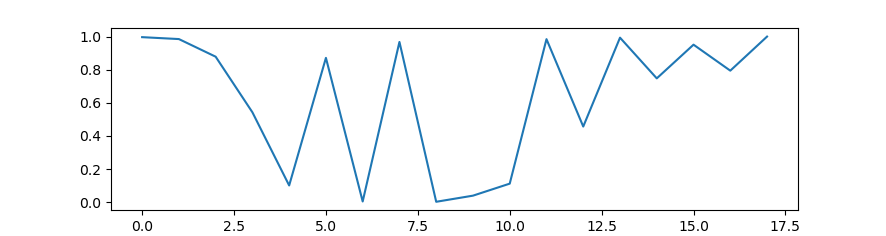

In [86]:
# fit the missings to places where overall transition fit is maximized

songs_final = songs_red

for m in missings:
    # find optimal position
    trans_fits = []
    best_fit = 0
    best_ind = -1
    for pos in range(2, len(songs_final) - 2):
        test_songs = songs_final[:pos+1] + [m] + songs_final[pos+1:]
        curr_fit = get_fit(test_songs)
        if curr_fit > best_fit:
            best_fit = curr_fit
            best_ind = pos
    songs_final = songs_final[:best_ind+1] + [m] + songs_final[best_ind+1:]

plt.figure()
plt.plot(get_fit(songs_final, False))

In [87]:
test_random_it(songs_final, True)

[False, False, True, False, False]

In [52]:
# adjacency does not look good, check
artists = [df_1[df_1[0] == s][4].tolist()[0] for s in songs_final]
artists

[None,
 'Muse',
 'Biffy Clyro',
 'Volbeat',
 'Vivid',
 'Craig Irving',
 'Stone Sour',
 'Biffy Clyro',
 'FINNEAS',
 None,
 None,
 'Travis',
 'FINNEAS',
 'Volbeat',
 'Vivid',
 'Biffy Clyro',
 'Grey Daze',
 'Queens of the Stone Age',
 None]

In [1]:
#TODO: optimize the artist transition criteria while removing/adding single songs (see while loops above)

In [88]:
# try to create WMP playlist
_m3u = open(mp3_path/"M_playlist_v2.m3u", "w")
for s in songs_final:
    _m3u.write(s + ".mp3\n")
_m3u.close()

In [93]:
# get songs that are not used
# just for overview
not_used = [s for s in df_1[0].tolist() if s not in songs_final]
not_used

['05 - Wait For You', 'New Born - Muse', 'Resistance - Muse']

change tracklist manually and save; use next cells to analyze changes

In [4]:
# load in tracklist
tracklist = "M_playlist_v2_manual.m3u"

In [6]:
f = open(mp3_path/tracklist, "r")
ll = f.readlines()
ll = [l.split("\n")[0] for l in ll]
ll = [l for l in ll if len(l) > 0 and not l.startswith("#EXT")]
ll = [l.split(".mp3")[0] for l in ll]

In [ ]:
# test the song list
print(test_random_it(ll, True))
plt.figure()
plt.plot(get_fit(ll, False))

In [39]:
# get tags from MP3s

song_names = []
artists = []
durs = []

for s in ll:
    # tag infos
    tag = eyed3.id3.tag.Tag()
    tag.parse(os.path.join(mp3_path, s+".mp3"))
    song_names.append(tag.title)
    artists.append(tag.artist)
    # song duration
    audio = MP3(os.path.join(mp3_path, s+".mp3"))
    durs.append(audio.info.length)

Frame 'SYLT' is not yet supported, using raw Frame to parse
Frame 'SYLT' is not yet supported, using raw Frame to parse


In [40]:
# manually insert missing artist/song name tags
artists[0] = "MGMT"
artists[3] = "Daniel Powter"
artists[-1] = "Daniel Powter"

song_names[0] = "The Youth"
song_names[3] = "Do You Wanna Get Lucky"
song_names[-1] = "Tell Them Who You Are"
song_names

['The Youth',
 'Knights of Cydonia',
 'Wait For You',
 'Do You Wanna Get Lucky',
 'Instant History',
 "What They'll Say About Us",
 'Off We Go',
 'Last Day Under the Sun',
 'Through Glass',
 'Valentine',
 'Still',
 'Let Go',
 'Tiny Indoor Fireworks',
 'Let It Burn',
 "Can't Wait To Be Dead Explicit",
 'Space',
 'Morei Sky',
 'I Sat by the Ocean',
 'Tell Them Who You Are']